In [1]:
# Function that does n iterations of RMS calculation

import numpy as np
import matplotlib.pyplot as plt

def mc_rms (y_array1, y_array2, unc1, unc2, n):
    """Does n iterations of RMS calculation.
    
    Arguments: y_array1, y_array2, unc1, unc2, n
    Outputs: [avg, error, RMS]"""
    
    plt.clf()
    
    RMS = []
    
    for w in range(n):
        y_array1_rand = y_array1 + (np.random.randn(len(y_array1)) * unc1)
        y_array2_rand = y_array2 + (np.random.randn(len(y_array2)) * unc2)
        diff = y_array1_rand - y_array2_rand
        rms = (np.sum(diff**2))/(len(diff))**(0.5)
        RMS.append(rms)
       
    avg = np.mean(RMS)
    error = np.std(RMS)
#     print('RMS = ',avg, '+/-', error)
#     print(avg)
    return [avg, error, RMS]
    
    RMS.sort()
#     plt.hist(RMS, bins=50)
#     plt.ylabel('Frequency')
#     plt.xlabel('RMS')
#     plt.show()

#     label = '/Users/victoriaditomasso/phys767/MCSpectra/hist_'+str(plot_title)+'.png'

#     plt.savefig(label)
    
#     print(RMS)

In [2]:
def snr_to_unc(unc_array):
    """Checks if an array is SNR or unc, converts an SNR array into an uncertainty array.
    
    Arguments: unc_array
    Outputs: unc"""

    unc=np.asarray(unc_array)
    avg_unc = np.sum(unc)/len(unc)
    if avg_unc > 4.0:
        unc = 1.0/unc
        
    return unc

In [3]:
# Probably not general enough to be its own function
def get_tar_data(tar_source_id, spec_order):

    """Queries database for wavelength, flux, uncertainty and RV for a given source_id & spectral order
    
    Arguments: tar_source_id, spec_order
    Outputs: [w_tar,f_tar,rv_tar,unc_tar]"""
    
    data_tar = db.query("select sources.id, sources.shortname, spectra.wavelength, spectra.flux, spectra.unc, radial_velocities.radial_velocity from sources join spectra on sources.id=spectra.source_id join radial_velocities on spectra.source_id=radial_velocities.source_id where spectra.source_id={} and spectra.wavelength_order={}".format(tar_source_id, spec_order))

    w_tar = np.asarray(data_tar[0][2])
    
    f_tar = np.asarray(data_tar[0][3])
    
    rv_tar = data_tar[0][5]
    
    unc_tar = data_tar[0][4]
    
    unc_tar = snr_to_unc(unc_tar)
    
    return [w_tar,f_tar,rv_tar,unc_tar]

In [4]:
# Probably not general enough to be its own function
def get_comp_data(spec_id) :
    
    """Queries database for wavelength, flux, uncertainty and RV for a given spectrum ID
    
    Arguments: spec_id
    Outputs: [w_comp,f_comp,rv_comp,unc_comp]"""
    
    data_comp = db.query("select spectra.wavelength, spectra.flux, spectra.unc from spectra where spectra.id={}".format(row['spec_id']))
    
    w_comp = np.asarray(data_comp[0][0])
    
    f_comp = np.asarray(data_comp[0][1])
    
    rv_comp = row['rv']
    
    unc_comp = data_comp[0][2]
    
    unc_comp = snr_to_unc(unc_comp)
    
    return [w_comp,f_comp,rv_comp,unc_comp]

In [5]:
# This doesn't need to be a function because it's only one line anyway
def rv_shift(wavelength, rv):
    
    """Shifts a spectrum based on its radial velocity
    
    Arguments: wavelength array, rv
    Outputs: shifted_wavelength"""
    
    shifted_wavelength = (wavelength) * (1.-(rv/2.99792458e5))

    return shifted_wavelength

In [6]:
# I don't think I need to write this, because there's already an interpolate function
def interpolate_spectra(w_tar,w_comp,f_comp,unc_comp):
    
    x = w_tar
    xp = w_comp
    fp = f_comp
    f_comp_interp = np.interp(x, xp, fp)
        
    w = w_tar
    wp = w_comp
    up = unc_comp
    unc_comp_interp = np.interp(w, wp, up)
    
    return [f_comp_interp, unc_comp_interp]

In [7]:
def normalize_spectra(f1,unc1,f2,unc2):
    
    """Normalized one spectrum to another
    
    Arguments: f1,unc1,f2,unc2
    Outputs: f2_norm"""
    
# Finds a normalization coefficient
    norm_coeff = sum((f1 * f2)/((unc1)**2 + (unc2)**2))/sum((f2 * f2)/((unc1)**2 + (unc2)**2))

# Creates an array of normalized flux for the comparison object
    f2_norm = f2 * norm_coeff
    
    return f2_norm

In [10]:
# Derived from ycfq_auto:

#yfcq_auto
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
from scipy.interpolate import interp1d
# import BDdb
import astrodb
import pandas as pd
%matplotlib inline
import matplotlib.mlab as mlab
from scipy.stats import norm

db = astrodb.Database('/Users/victoriaditomasso/Desktop/BDNYCdeprecated.db')

# The inputs are the target source id, the spec order being compared and the path to the text file with the comparison sample (has to be tab delimited)
def yfcq(tar_source_id, spec_order, path_to_comp_sample_dataframe):

# This clears the figure, useful when saving the plots
    plt.clf()

# Queries the database for target data
    data_tar = db.query("select sources.id, sources.shortname, spectra.wavelength, spectra.flux, spectra.unc, radial_velocities.radial_velocity from sources join spectra on sources.id=spectra.source_id join radial_velocities on spectra.source_id=radial_velocities.source_id where spectra.source_id={} and spectra.wavelength_order={}".format(tar_source_id, spec_order))

# Separates the target data into separate variables (wavelength, flux, RV, uncertainty)
    w_tar = np.asarray(data_tar[0][2])
    f_tar = np.asarray(data_tar[0][3])
    rv_tar = data_tar[0][5]
    unc_tar = data_tar[0][4]

# Reads in the dataframe
    df=pd.read_csv(path_to_comp_sample_dataframe,sep='\t')

# Empty lists to be populated in the forloop
    RMSs=[]
    sigmas=[]
    
# Iterates through all of the comparison objects in the dataframe
    for i, row in df.iterrows() :

        plt.clf()
        
# Queries the database for comparison object data
        data_comp = db.query("select spectra.wavelength, spectra.flux, spectra.unc from spectra where spectra.id={}".format(row['spec_id']))

# Separates the comparison data into separate variables (wavelength, flux, RV, uncertainty)
        w_comp = np.asarray(data_comp[0][0])
        f_comp = np.asarray(data_comp[0][1])
        rv_comp = row['rv']
        unc_comp = data_comp[0][2]
    
# Will convert an SNR array to an uncertainty array
        unc_comp = snr_to_unc(unc_comp)

# Shifts spectra based on their RVs
        w_tar = rv_shift(w_tar, rv_tar)
        w_comp = rv_shift(w_comp, rv_comp)

# Interpolates comparison spectrum and comparison unc
# Remember: once you interpolate, you need to plot the w_tar vs the interpolated flux NOT w_comp vs interpolated flux
        f_comp = np.interp(w_tar, w_comp, f_comp)
        unc_comp = np.interp(w_tar, w_comp, unc_comp)
        
        f_comp = normalize_spectra(f_tar,unc_tar,f_comp,unc_comp)
        
        return [w_tar,f_tar,unc_tar,w_comp,f_comp,unc_comp]
    
    
    
    
    
    
    
    
########################
# PROBLEM: NEEDS TO BE IN FORLOOP, UNLESS I SAVE THE RESULTS OF THE PREVIOUS FUNCTION AND THEN CALL THAT


# Calculate RMS and makes spectral plots
        
# Sets the first and last flux point that will be used in quantification calculation/will be plotted
        f=50
        l=1000
        
# MC_rms calculation
        
        y_array1 = f_tar[f:l]
        y_array2 = f_comp[f:l]
        unc1 = unc_tar[f:l]
        unc2 = unc_comp[f:l]

#         plot_title=str(row['shortname']) + '_' + str(data_tar[0][1])
#         plt.savefig('/Users/victoriaditomasso/phys767/MCSpectra/hist_'+str(plot_title)+'.png')
        
#         fig, axes = plt.subplots(4,1)
#         fig=plt.figure()
#         iterations = [100,200,500,1000]
        
        fig = plt.subplots(4,1) 
    
#         for i in [1000, 1500, 2000, 2500]:
        
        iterations = 1000
    
        rms = mc_rms(y_array1, y_array2, unc1, unc2, iterations)
            
#             plt.hist(rms[2],bins=25, normed=True)
#             plt.title(i)
            
        mean = np.mean(rms[2])
        RMSs.append(mean)
        
        variance = np.var(rms[2])
        
        sigma = np.sqrt(variance)
        sigmas.append(sigma)
        
#         x = np.linspace(min(rms[2]), max(rms[2]), 100)
#         plt.plot(x, mlab.normpdf(x, mean, sigma))
        print('mean = ', mean, 'sigma = ', sigma)
            
#         column_title = 'RMS n=' + str(i)
#         df[column_title] = rms[0]

        plot_title=str(row['shortname']) + '-' + str(row['spec_id']) + '_' + str(data_tar[0][1])
        plt.plot(w_tar[f:l],f_tar[f:l], color='black')
        plt.plot(w_tar[f:l],f_comp[f:l], color='r')
#         plt.fill_between(shifted_w_tar[f:l],f_tar[f:l]+unc_tar[f:l], f_tar[f:l]-unc_tar[f:l], color='black', alpha=0.3)
#         plt.fill_between(shifted_w_comp[f:l], f_comp_norm_dk_interp[f:l]+unc_comp_interp[f:l], f_comp_norm_dk_interp[f:l]-unc_comp_interp[f:l], color='r', alpha=0.3)
        plt.ylabel('wavelength')
        plt.xlabel('flux')
        plt.savefig('/Users/victoriaditomasso/phys767/MCSpectra/RMS_'+str(plot_title)+'.png')
        plt.show()
        plt.close()
        
    df['RMS'] = RMSs
    df['sigma'] = sigmas

    df.to_csv(str(data_tar[0][1])+'_RMS_bad_removed.txt',sep='\t')
        
#             (rms[0],rms[1]) = norm.fit(rms[2])
#             y = mlab.normpdf(25,rms[0],rms[1])
#             x = np.linspace(min(rms[2]),max(rms[2]),num=len(y))
#             plt.plot(x,y)





############################
#  Histograms


#         plot_title=str(row['shortname']) + '_' + str(data_tar[0][1])
#         plt.savefig('/Users/victoriaditomasso/phys767/MCSpectra/hist_'+str(plot_title)+'.png')
        
# #         fig, axes = plt.subplots(4,1)
# #         fig=plt.figure()
# #         iterations = [100,200,500,1000]
        
#         fig = plt.subplots(4,1) 
    
#         for i in [1000, 1500, 2000, 2500]:
            
#             rms = mc_rms(y_array1, y_array2, unc1, unc2, i)
            
#             plt.hist(rms[2],bins=25, normed=True)
#             plt.title(i)
            
#             mean = np.mean(rms[2])
#             variance = np.var(rms[2])
#             sigma = np.sqrt(variance)
#             x = np.linspace(min(rms[2]), max(rms[2]), 100)
#             plt.plot(x, mlab.normpdf(x, mean, sigma))
#             print('mean = ', mean, 'sigma = ', sigma)
            
#             column_title = 'RMS n=' + str(i)
#             df[column_title] = rms[0]
#             df.to_csv(str(data_tar[0][1])+'_'+str(spec_order)+'testing_mc.txt',sep='\t')
#             plot_title=str(row['shortname']) + '_' + str(data_tar[0][1]) + '_' +str(i)
        
# #             (rms[0],rms[1]) = norm.fit(rms[2])
# #             y = mlab.normpdf(25,rms[0],rms[1])
# #             x = np.linspace(min(rms[2]),max(rms[2]),num=len(y))
# #             plt.plot(x,y)
#             plt.show()
            
#             plt.savefig('/Users/victoriaditomasso/phys767/MCSpectra/hist_'+str(plot_title)+'.png')


Database ready for use


mean =  0.101573465711 sigma =  0.0028729017062


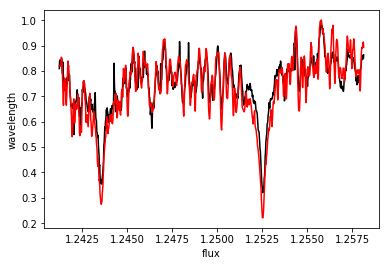

mean =  0.120591515295 sigma =  0.00263413915844


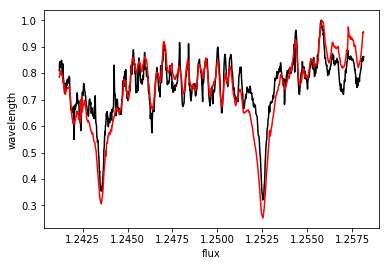

mean =  0.0852431180077 sigma =  0.00227904430664


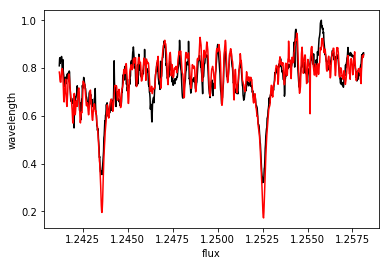

KeyboardInterrupt: 

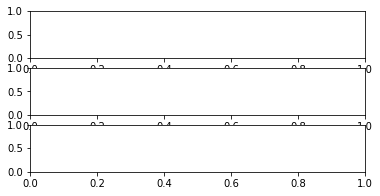

In [11]:
yfcq(334, 61, "/Users/victoriaditomasso/phys767/comp_sample_order_61_bad_removed.txt")

In [ ]:
yfcq(98, 61, "/Users/victoriaditomasso/Plotting_Spectra/comp_sample_order_61_badremoved.txt")

In [ ]:
plt.plot([1,2])
plt.savefig('test.png')
plt.close()

In [ ]:
help(mc_rms)